In [1]:
!unzip -o data/hpc.csv.zip -d data
!unzip -o data/vegashrinker.csv.zip -d data

Archive:  data/hpc.csv.zip
  inflating: data/hpc.csv            
Archive:  data/vegashrinker.csv.zip
  inflating: data/vegashrinker.csv   


In [2]:
# ============================================================
# Notebook setup
# ============================================================

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 3)

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from util import nn
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Load data
data_folder = 'data'
hpc = pd.read_csv(data_folder+ '/hpc.csv', parse_dates=['timestamp'])

# Identify input columns
inputs = hpc.columns[1:-1]
ninputs = len(inputs)

# Autoencoders for Anomaly Detection

## High Performance Computing

**High Performance Computing**

HPC refers to HW/SW infrastructures for particularly intensive workloads

<center><img src="assets/supercomputers.jpg" width=900px/></center>

## High Performance Computing

**HPC is (somewhat) distinct from cloud computing**

* Cloud computing is mostly about running (and scaling services)
* ...HPC is all about _performance_

Typical applications: simulation, massive data analysis, training large ML models

**HPC systems follow a batch computation paradigm**

* Users send _jobs_ to the systems (i.e. configuration for running a program)
* Jobs end in one of several _queues_
* A _job scheduler_ draws from the queue
* ...And dispatches jobs to computational _nodes_ for execution

## High Performance Computing

**HPC systems can be large and complex**

E.g. Marconi-100 at CINECA, the 9-th most powerful supercompuer [(as of June 2020)](https://www.top500.org/lists/top500/2020/06/)

<center><img src="assets/marconi.png" width=900px/></center>

* The system has 347,776 cores overall!

**Configuring (and maintaining the configuration) of these systems**

* ...Is of paramount important, as it has an impact on the performance
* ...Is very challenging, due to their _large scale_ and the presence of _node heterogeneity_ 

Hence the interest in _detecting anomalous conditions_


## The Dataset

**As an example, we will consider the DAVIDE system**

Small scale, energy-aware architecture:

* Top of the line components (at the time), liquid cooled
* An advanced monitoring and control infrastructure (ExaMon)
* ...Developed together with UniBo

The system went out of production in January 2020

**The monitoring system enables anomaly detection**

* Data is collected from a number of samples with high-frequency
* Long term storage only for averages over 5 minute intervals
* Anomalies correspond to unwanted configurations of the _frequency governor_
* ...Which can throttle performance to save power or prevent overheating

## A Look at the Dataset

**Our dataset refers to the non-idle periods of a single node**

In [3]:
print(f'#examples: {hpc.shape[0]}, #columns: {hpc.shape[1]}')
hpc.iloc[:3]

#examples: 6667, #columns: 161


,timestamp,ambient_temp,cmbw_p0_0,cmbw_p0_1,cmbw_p0_10,cmbw_p0_11,cmbw_p0_12,cmbw_p0_13,cmbw_p0_14,cmbw_p0_2,...,util_p0_5,util_p0_6,util_p0_8,util_p0_9,volt_v0_1,volt_v0_2,volt_v1_1,volt_v1_2,winkcnt_p0_2,anomaly
0,2018-03-05 22:45:00,0.165639,0.006408,0.012176,0.166835,0.238444,0.230092,0.145691,0.227682,0.000094,...,0.056146,0.007334,0.009948,0.015761,0.076402,0.727967,0.075536,0.787213,1.0,0
1,2018-03-05 22:50:00,0.139291,0.007772,0.057400,0.166863,0.238485,0.230092,0.145691,0.227682,0.176855,...,0.998460,0.742089,0.010209,0.019240,0.999908,0.727514,0.999856,0.787024,1.0,0
2,2018-03-05 22:55:00,0.141048,0.000097,0.000000,0.166863,0.238444,0.230092,0.145691,0.227682,0.252403,...,0.239957,0.838108,0.010262,0.025894,0.999918,0.727514,0.999870,0.787024,1.0,0


* This still a time series, but a _multivariate_ one

## A Look at the Dataset

**How to display a multivariate series? Approach #1: showing _individual columns_**

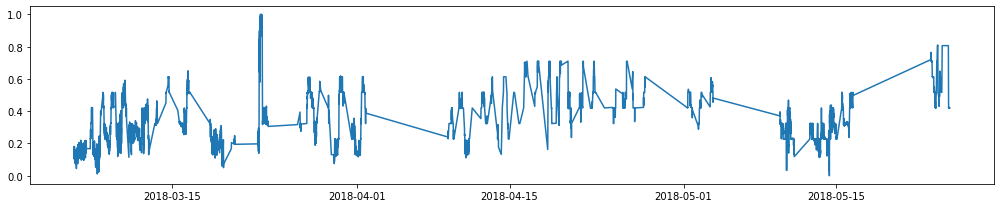

In [4]:
tmp = pd.Series(index=hpc['timestamp'], data=hpc[inputs[0]].values)
nn.plot_series(tmp, figsize=figsize)

* The series contains significant gaps (i.e. the idle periods)

## A Look at the Dataset

**Approach #2: obtaining _statistics_**

In [5]:
hpc[inputs].describe()

,ambient_temp,cmbw_p0_0,cmbw_p0_1,cmbw_p0_10,cmbw_p0_11,cmbw_p0_12,cmbw_p0_13,cmbw_p0_14,cmbw_p0_2,cmbw_p0_3,...,util_p0_4,util_p0_5,util_p0_6,util_p0_8,util_p0_9,volt_v0_1,volt_v0_2,volt_v1_1,volt_v1_2,winkcnt_p0_2
count,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,...,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000
mean,0.357036,0.138162,0.060203,0.119616,0.160606,0.184970,0.118305,0.151434,0.143033,0.147800,...,0.509612,0.716533,0.766818,0.202598,0.202650,0.808665,0.481398,0.808170,0.512920,0.626519
std,0.166171,0.128474,0.090796,0.098597,0.128127,0.163190,0.104490,0.120793,0.125052,0.138610,...,0.479815,0.424887,0.400454,0.388927,0.389502,0.386906,0.379362,0.387440,0.400457,0.483765
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.227119,0.000073,0.000020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000117,0.000056,...,0.000200,0.198757,0.678980,0.000000,0.000000,0.999887,0.000000,0.999827,0.000000,0.000000
50%,0.323729,0.136095,0.000082,0.166835,0.238444,0.230092,0.145691,0.227682,0.174933,0.138148,...,0.517715,0.999260,0.999380,0.010074,0.009918,0.999908,0.727514,0.999856,0.787024,1.000000
75%,0.470254,0.261908,0.134976,0.166984,0.238566,0.230406,0.145908,0.227779,0.251910,0.299604,...,0.999523,0.999828,0.999907,0.016749,0.023519,0.999928,0.727514,0.999885,0.787024,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* No missing value, _normalized_ data

## A Look at the Dataset

**Approach #3: standardize, then use a _heatmap_**

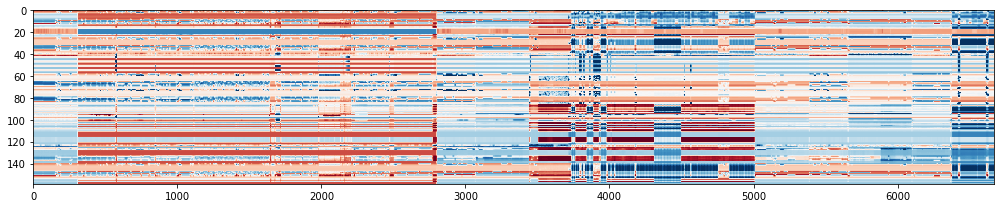

In [6]:
hpcsv = hpc.copy()
hpcsv[inputs] = (hpcsv[inputs] - hpcsv[inputs].mean()) / hpcsv[inputs].std()
nn.plot_dataframe(hpcsv[inputs], figsize=figsize)

* White = mean, red = below mean, blue = above mean

## Anomalies

**There are three possible configurations of the frequency governor:**

* Mode 0 or "normal": frequency proportional to the workload
* Mode 1 or "power saving": frequency always at the minimum value
* Mode 2 or "performance": frequency always at the maximum value

**On this dataset, this information is known**

...And it will serve as our ground truth

* We will focus on discriminating normal from non-normal behavior
* I.e. we will treat both "power saving" and "performance" configurations as anomalous

**Detecting them will be _challenging_**

* Since the signals vary so much when the running job changes

## Anomalies

**We can plot the location of the anomalies:**

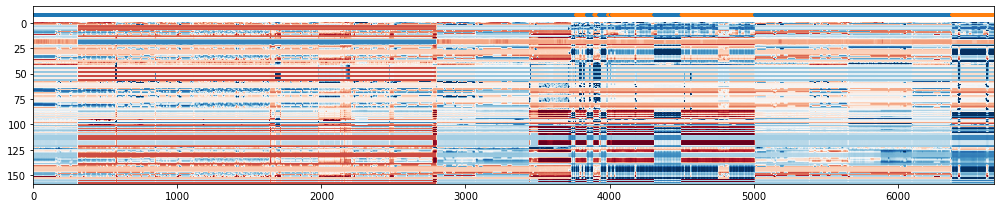

In [7]:
labels = pd.Series(index=hpcsv.index, data=(hpcsv['anomaly'] != 0), dtype=int)
nn.plot_dataframe(hpcsv[inputs], labels, figsize=figsize)

* On the top, blue = normal, orange = anomaly

# A KDE Approach

##  KDE Approach

**Let's try first a density estimation approach (once again using KDE)**

First, we need to _standardize_ the data again, based on _training information alone_

In [8]:
tr_end, val_end = 3000, 4500

hpcs = hpc.copy()
tmp = hpcs.iloc[:tr_end]
hpcs[inputs] = (hpcs[inputs] - tmp[inputs].mean()) / tmp[inputs].std()

* This is needed so that we do not accidentally exploit test set information
* The training set separator was chosen so as not to include anomalies

**Then we can separate training, validation, and test data:**

In [9]:
trdata = hpcs.iloc[:tr_end]
valdata = hpcs.iloc[tr_end:val_end]
tsdata = hpcs.iloc[val_end:]

## A KDE Approach

**Then we estimate the optimal bandwidth:**

In [10]:
params = {'bandwidth': np.linspace(0.1, 1, 10)}
opt = GridSearchCV(KernelDensity(kernel='gaussian'), params, cv=5)
opt.fit(trdata[inputs])
opt.best_params_

{'bandwidth': 0.5}

**...Ad we can train the estimator and generate the anomaly signal:**

In [11]:
h = opt.best_params_['bandwidth']
kde = KernelDensity(bandwidth=h)
kde.fit(trdata[inputs])
ldens = kde.score_samples(hpcs[inputs])
signal_kde = pd.Series(index=hpcs.index, data=-ldens)

* Tuning the bandwidth and obtaining densities are relatively expensive operations

## KDE Approach

**There is _a good match_ with the anomalies, but also many _spurious peaks_**

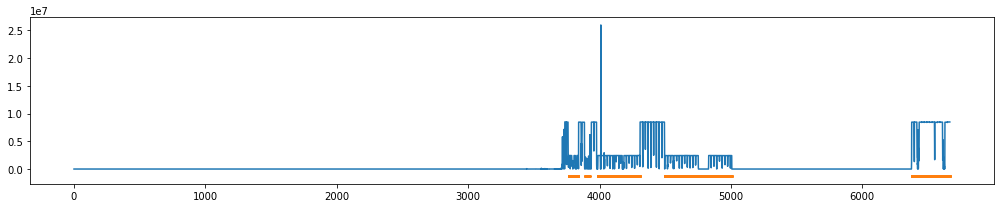

In [12]:
nn.plot_signal(signal_kde, labels, figsize=figsize)

* This is mostly due to the large variations due to job changes

## KDE Approach

**We then need to define the threshold, but for that we need a cost model**

Our main goal is to detect anomalies, not anticipating them

* Misconfigurations in HPC are usually not critical 
* ...And cause little issue, unless they stay unchecked for very long

**We will use a simple _cost model_:**

* $c_{\mathit{alarm}}$ for false positive (erroneous detections)
* $c_{\mathit{missed}}$ for false negatives (undetected anomalies)
* Detections are fine as long as they are within $\mathit{tolerance}$ units from the anomaly

In [13]:
c_alarm, c_missed, tolerance = 1, 5, 12
cmodel =  nn.HPCMetrics(c_alarm, c_missed, tolerance)

The implementation details can be found in the `nn` utility module

## KDE Approach

**We can now optimize the threshold over the validation set**

In [14]:
th_range = np.linspace(1e4, 1e5, 100)
th_kde, val_cost_kde = nn.opt_threshold(signal_kde[tr_end:val_end],
                                        valdata['anomaly'],
                                        th_range, cmodel)
print(f'Best threshold: {th_kde}')
tr_cost_kde = cmodel.cost(signal_kde[:tr_end], hpcs['anomaly'][:tr_end], th_kde)
print(f'Cost on the training set: {tr_cost_kde}')
print(f'Cost on the validation set: {val_cost_kde}')
ts_cost_kde = cmodel.cost(signal_kde[val_end:], hpcs['anomaly'][val_end:], th_kde)
print(f'Cost on the test set: {ts_cost_kde}')

Best threshold: 82727.27272727274
Cost on the training set: 0
Cost on the validation set: 266
Cost on the test set: 265


* The `opt_threshold` function runs the usual line search process
* In this case the training and validation set are completely separated

## The Trouble with KDE

**KDE-based approach works well, but have some _issues_**

First, KDE itself runs into trouble with high-dimensional data:

* With a larger dimensionality, _prediction times_ grows...
* ...And _more data_ is needed to obtain reliable results
* We are not seeing that too much, but eventually it will become a problem

Second, KDE gives you _nothing more_ than an anomaly signal

* Determining the cause of the anomaly is up to a domain expert
* ...Who needs to take a look at all the supposed anomalous data
* This is doable in low-dimensional spaces, but _way harder on high-dimensional one_

# Autoencoders for Anomaly Detection

## Autoencoders

**An autoencoder is _a type of neural network_**

The network is designed to _reconstruct its input vector_

* The input is some tensor $x$ and the output _should be_ the same tensor $x$

**Autoencoders can be broken down in two halves**

* An encoding part, i.e. $\mathit{encode}(x, \theta_e)$, mapping $x$ into a vector of _latent variables $z$_
* A decoding part, i.e. $\mathit{decode}(z, \theta_d)$, mapping $z$ into reconstructed input tensor

**Autoencoders are trained so as to satisfy:**

$$
\mathit{decode}(\mathit{encode}(\hat{x}_i, \theta_e), \theta_d) \simeq \hat{x}_i
$$

* I.e. $\mathit{decode}$, when applied to the output of $\mathit{encode}$
* ...Should approximately return the input vector itself

A nice introduction and tutorial about autoencoders can be found [on the Keras blog](https://blog.keras.io/building-autoencoders-in-keras.html)

## Autoencoders

**Formally, we typically employ an MSE loss**

$$
L(\theta_e, \theta_d) = \sum_{i=1}^n \left\|\hat{x}_i - \mathit{decode}(\mathit{encode}(\hat{x}_i, \theta_e), \theta_d)\right\|_2^2
$$

* This is trivial to satisfy if both $\mathit{encode}$ and $\mathit{decode}$ learn an identity relation
* ...So we need to prevent that

**There are _two main approaches_ to avoid learning a trivial mapping**

* Using an _information bottleneck_, i.e. making sure that $z$ has fewer dimensions that $x$
* Use a regularization to enforce _sparse encodings_, e.g.:

$$
L(\theta_e, \theta_d) = \sum_{i=1}^n \left\|\hat{x}_i - \mathit{decode}(\mathit{encode}(\hat{x}_i, \theta_e), \theta_d)\right\|_2^2 + \alpha \| \mathit{encode}(x, \theta_e) \|_1
$$

## Autoencoders for Anomaly Detection

**Autoencoders can be used for anomaly detection**

...By using the _reconstruction error as an anomaly signal_, e.g.:

$$
\left\|x - \mathit{decode}(\mathit{encode}(x, \theta_e), \theta_d)\right\|_2^2 > \theta
$$

**This approach has some PROs and CONs:**

* Compared to KDE
  - Neural Networks have good _support for high dimensional data_
  - ...Plus _limited overfitting_ and _fast prediction/detection time_
  - However, error reconstruction can be _harder than density estimation_
* Compared to autoregressors
  - Reconstructing an input is _easier than predicting the future_
  - ...So, we tend to get higher reliability


## Autoencoders in Keras

**Let's build an autoencoder in practice (with tensorflow 2.0 and keras)**

First, we build the model using (e.g.) the functional API

In [15]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

input_shape = (len(inputs), )
ae_x = keras.Input(shape=input_shape, dtype='float32')
ae_z = layers.Dense(64, activation='relu')(ae_x)
ae_y = layers.Dense(len(inputs), activation='linear')(ae_z)
ae = keras.Model(ae_x, ae_y)

* `Input` builds the entry point for the input data
* `Dense` builds a fully connected layer
* "Calling" layer A with parameter B attaches B to A
* `Model` builds a model object with the specified input and output

## Autoencoders in Keras

**Then we can prepare our model for training**

In keras terms, we _compile_ it:

In [16]:
ae.compile(optimizer='RMSProp', loss='mse')

* We are using the `RMSProp` optimizer (a variant of Stochastic Gradient Descent)

**Then we can start training:**

In [17]:
cb = [callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
history = ae.fit(trdata[inputs], trdata[inputs], validation_split=0.1,
                 callbacks=cb,
                 batch_size=32, epochs=20, verbose=0)

* We are using a callback to stop training early
* ...If no improvement on the validation set is observed for 3 epochs

## Autoencoders in Keras

**Let's have a look at the loss evolution over different epochs**

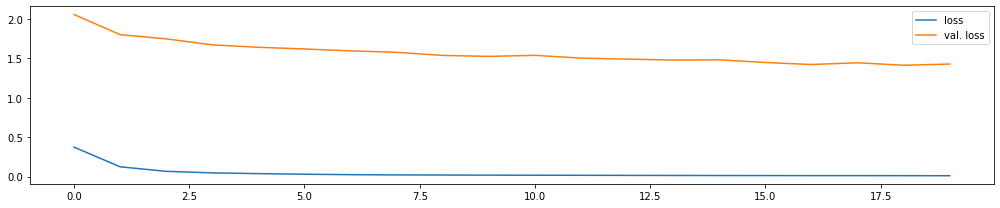

In [18]:
nn.plot_training_history(history, figsize=figsize)

## Autoencoders in Keras

**Finally, we can obtain the predictions**

In [19]:
preds = pd.DataFrame(index=hpcs.index, columns=inputs, data=ae.predict(hpcs[inputs]))
preds.head()

,ambient_temp,cmbw_p0_0,cmbw_p0_1,cmbw_p0_10,cmbw_p0_11,cmbw_p0_12,cmbw_p0_13,cmbw_p0_14,cmbw_p0_2,cmbw_p0_3,...,util_p0_4,util_p0_5,util_p0_6,util_p0_8,util_p0_9,volt_v0_1,volt_v0_2,volt_v1_1,volt_v1_2,winkcnt_p0_2
0,-2.067214,-1.001210,0.985324,2.419332,2.142722,2.067093,2.513897,2.893859,-1.284258,-1.171458,...,-1.135513,-0.767396,-1.547279,1.648612,2.163350,-6.752384,2.338249,-6.103269,2.055166,2.407145
1,-1.132676,-0.749727,0.273170,2.444315,2.436926,2.525956,2.361582,2.363032,0.299280,-0.577058,...,0.683704,0.131589,0.163578,2.118543,2.925787,0.152254,2.588315,0.227656,2.295278,2.368891
2,-0.917742,-0.898875,-0.229904,2.388648,2.521980,2.591781,2.370935,2.544580,0.409896,0.862515,...,0.786087,-1.035501,0.451636,2.152368,3.101333,0.454824,2.442592,0.295075,2.425052,2.372971
3,-1.052092,-0.716448,-0.230684,2.517216,2.523437,2.584244,2.399754,2.540465,0.580172,1.353403,...,0.792541,0.403487,-1.312758,2.159958,3.033641,0.438924,2.584077,0.295387,2.395891,2.432157
4,-0.988906,-0.854139,-0.150999,2.531802,2.585943,2.577478,2.414372,2.518947,0.594570,1.067536,...,0.791409,0.265188,-1.188254,2.233721,3.141183,0.449178,2.543773,0.323782,2.453508,2.445017


## Alarm Signal

**We can finally obtain our alarm signal, i.e. the sum of squared errors**

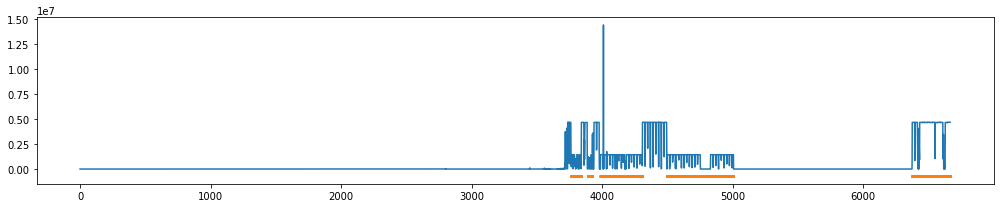

In [20]:
sse = np.sum(np.square(preds - hpcs[inputs]), axis=1)
signal_ae = pd.Series(index=hpcs.index, data=sse)
nn.plot_signal(signal_ae, labels, figsize=figsize)

* It is apparently quite similar to the KDE signal

## Threshold Optimization

**Then we can optimize the threshold as usual**

In [21]:
th_ae, val_cost_ae = nn.opt_threshold(signal_ae[tr_end:val_end],
                                        hpcs['anomaly'][tr_end:val_end],
                                        th_range, cmodel)
print(f'Best threshold: {th_ae}')
tr_cost_ae = cmodel.cost(signal_ae[:tr_end], hpcs['anomaly'][:tr_end], th_ae)
print(f'Cost on the training set: {tr_cost_ae}')
print(f'Cost on the validation set: {val_cost_ae}')
ts_cost_ae = cmodel.cost(signal_ae[val_end:], hpcs['anomaly'][val_end:], th_ae)
print(f'Cost on the test set: {ts_cost_ae}')

Best threshold: 99090.90909090909
Cost on the training set: 0
Cost on the validation set: 264
Cost on the test set: 265


* We have more or less the same performance as KDE

## Mutiple Signal Analysis

**But autoencoders do _more than just anomaly detection_!**

* Instead of having a single signal we have _many_
* So we can look at the _individual_ reconstruction errors

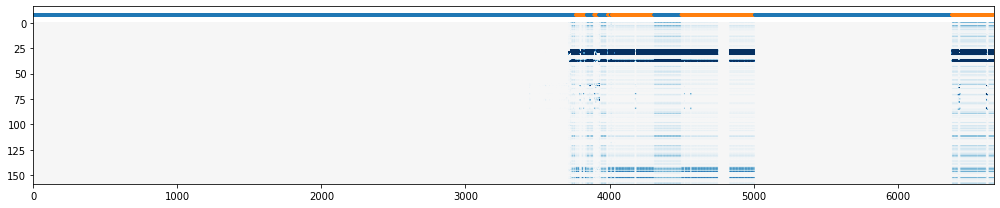

In [22]:
se = np.square(preds - hpcs[inputs])
signals_ae = pd.DataFrame(index=hpcs.index, columns=inputs, data=se)
nn.plot_dataframe(signals_ae, labels, vmin=-5e4, vmax=5e4, figsize=figsize)

## Mutiple Signal Analysis

**Reconstruction errors are often concentrated on a few signals**

* These correspond to the properties of the input vector that were harder to reconstruct
* ...And often they are useful clues about the _nature of the anomaly_

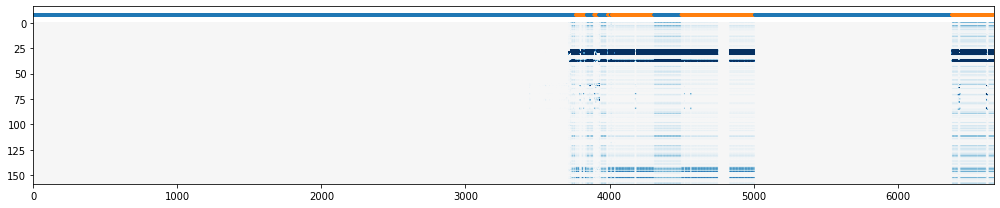

In [23]:
se = np.square(preds - hpcs[inputs])
signals_ae = pd.DataFrame(index=hpcs.index, columns=inputs, data=se)
nn.plot_dataframe(signals_ae, labels, vmin=-5e4, vmax=5e4, figsize=figsize)

## Multiple Signal Analysis

**Let's focus on the last _mode 1_ anomaly ("power saving" mode)**

Here are the 8 largest errors in descending order

In [24]:
last_mode_1 = hpcs.index[hpcs['anomaly']==1][-1]
se.iloc[last_mode_1].sort_values(ascending=False)[:8]

ips_p0_14     297157.478200
ips_p0_10     232936.588880
ips_p0_12     167398.891636
ips_p0_11     145956.375419
ips_p0_8       91978.717464
ips_p0_9       63883.415130
util_p0_14     39957.234299
util_p0_8      35968.635223
Name: 5006, dtype: float64

* They are mostly related to performance (e.g. "ips" - Instructions Per Second)
* ...As it should be!

## Multiple Signal Analysis

**Now, let's move to the last _mode 2_ anomaly ("performance" mode)**

Here are the 8 largest errors in descending order

In [25]:
last_mode_2 = hpcs.index[hpcs['anomaly']==2][-1]
se.iloc[last_mode_2].sort_values(ascending=False)[:8]

ips_p0_14     1.113248e+06
ips_p0_10     9.050813e+05
ips_p0_12     6.706251e+05
ips_p0_11     5.538771e+05
ips_p0_8      3.577486e+05
ips_p0_9      2.538609e+05
ips_p0_13     4.589716e+04
util_p0_14    2.695178e+04
Name: 6666, dtype: float64

* Again, they are performance related

## Multiple Signal Analysis

**Here are the _average errors_ for mode 1 anomalies**

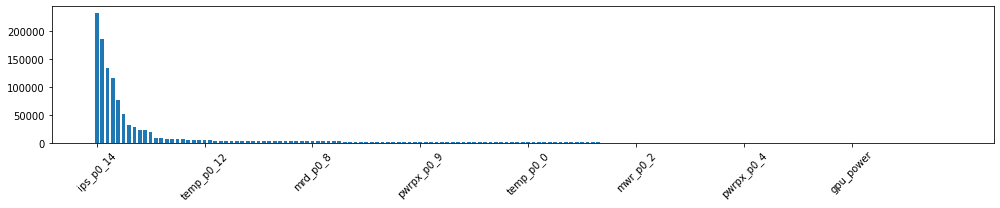

In [26]:
mode_1 = hpcs.index[hpcs['anomaly']==1]
tmp =  se.iloc[mode_1].mean().sort_values(ascending=False)
nn.plot_bars(tmp, tick_gap=20, figsize=figsize)

* Errors are concentrated on 10-20 features

## Multiple Signal Analysis

**These are the 20 _largest_ average errors for _mode 1_ anomalies**

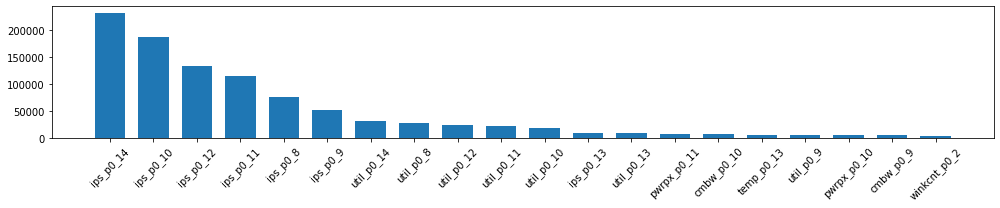

In [27]:
mode_1 = hpcs.index[hpcs['anomaly']==1]
tmp =  se.iloc[mode_1].mean().sort_values(ascending=False)
nn.plot_bars(tmp.iloc[:20], figsize=figsize)

* The largest errors are on "ips", then on "util" (utilization)

## Multiple Signal Analysis

**Let's repeat the analysis for _mode 2_. Here are the _average errors_**

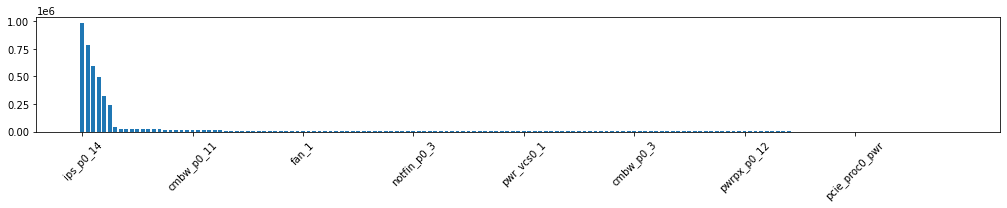

In [28]:
mode_2 = hpcs.index[hpcs['anomaly']==2]
tmp =  se.iloc[mode_2].mean().sort_values(ascending=False)
nn.plot_bars(tmp, tick_gap=20, figsize=figsize)

* The situation is similar to mode 1

## Multiple Signal Analysis

**The 20 _largest_ average errors for _mode 2_**

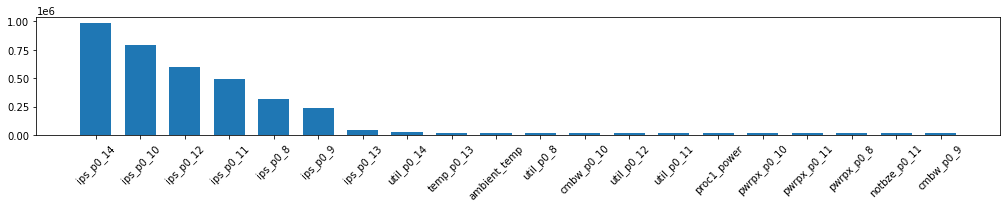

In [29]:
mode_2 = hpcs.index[hpcs['anomaly']==2]
tmp =  se.iloc[mode_2].mean().sort_values(ascending=False)
nn.plot_bars(tmp.iloc[:20], figsize=figsize)

* The largest errors are on "ips", then on power signals

## Considerations

**Autoenders can be used for anomaly detection**

* The provide the usual benefits of Neural Networks
  - E.g. scalability, limited overfitting, limited need for preprocessing
* They tend to be more reliable than autoregressors
* They provide more fine grained information than density estimation
* ...And you can make them _deep_!

**Analyzing individual efforts provides clues about the anomalies**

* In this case, we manage to focus on 10-20 features, rather than 160!

**Density estimation is (usually) a bit better at pure anomaly detection**

* ...But there is no reason not to use both approaches!
* E.g. density estimation for detection, autoencoders for the analysis